# Modeling uncertainty in time series forecasting

In some use cases, we are interested in knowing how probable our forecast is. Predictive models are biased towards the mean, as we consider over and under predictions at the same cost. 

Before starting, it is worth mentioning that prediction intervals and confidence intervals are not the same thing. 

A **prediction interval** is an interval associated with a random variable yet to be observed, with a specified probability of the random variable lying within the interval. 

A **confidence interval** is an interval associated with a parameter and is a frequentist concept. The parameter is assumed to be non-random but unknown, and the confidence interval is computed from data. Because the data are random, the interval is random. A 95% confidence interval will contain the true parameter with probability 0.95. That is, with a large number of repeated samples, 95% of the intervals would contain the true parameter.

https://robjhyndman.com/hyndsight/intervals/

In this tutorial, we will work with the daily total female births dataset

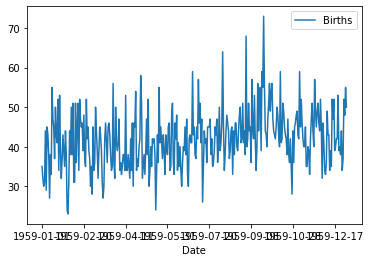

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
series.plot()
pyplot.show()

Some libraries already include confidence intervals for their predictions. For example, statsmodels ARIMA gives the option to retrieve the standard error and the confidence interval. We can specify the confidence by setting the value alpha in the conf_int method.

In [2]:
# summarize the confidence interval on an ARIMA forecast
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split into train and test sets
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit()
# forecast
result = model_fit.get_forecast()
# summarize forecast and confidence intervals
print('Expected: %.3f' % result.predicted_mean)
print('Real: %.3f' % test[0])
print('Standard Error: %.3f' % result.se_mean)
ci = result.conf_int(0.05)
print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))

Expected: 45.149
Real: 50.000
Standard Error: 7.009
95% Interval: 31.413 to 58.886


https://machinelearningmastery.com/time-series-forecast-uncertainty-using-confidence-intervals-python/

We are interested in computing prediction intervals for all forecasting models. One approach that I've seen on the internet consists in using bootstrapping samples to estimate the prediction error. The problem that I've found is that time series data is not iid, so this approaches cannot be directly applied.
One option that could be useful would be to use a sliding window splitter to produce versions of the time series, fit the model, compute the prediction errors, and set the mean error as an estimate of the prediction error.

In [12]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import make_reduction

In [13]:
split = int(len(series)*0.8)
y_total = series.values
y_train = X[:split]
y_test = X[split:]
window = len(y_test)

Find the best parameters for a Linear regression model

In [15]:
y = pd.Series(y_train)
fh = np.arange(1, window+1)
forecaster = PolynomialTrendForecaster()
param_grid = {"degree" : [1,2]}
cv = SlidingWindowSplitter(window_length=100)
gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=param_grid)
gscv.fit(y, fh=fh)
y_pred = gscv.predict(fh)

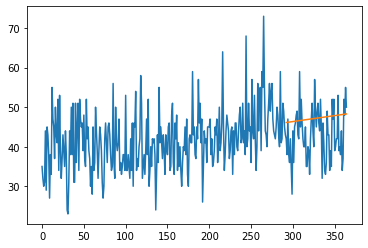

In [16]:
plt.plot(np.arange(len(y_total)), y_total)
plt.plot(np.arange(split, split+len(y_pred)), y_pred)
plt.show()

Estimate the prediction error and plot upper and lower bounds

In [17]:
def estimate_pred_err(y, forecaster, cv):
    errors = []
    for i, (train, test) in enumerate(cv.split(y)):
        forecaster.fit(y[train], fh=cv.fh)
        pred = forecaster.predict(cv.fh)
        error = abs(pred-y[test])
        errors.append(error.values)
    errors = np.array(errors)
    mean_error = np.mean(errors, axis = 0)
    return mean_error

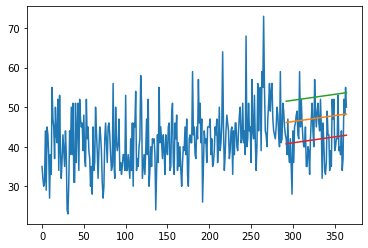

In [18]:
mean_error = estimate_pred_err(y,gscv.best_forecaster_, cv)
upper_bound = y_pred + mean_error
lower_bound = y_pred - mean_error
plt.plot(np.arange(len(y_total)), y_total)
plt.plot(np.arange(split, split+len(y_pred)), y_pred)
plt.plot(np.arange(split, split+len(y_pred)), upper_bound)
plt.plot(np.arange(split, split+len(y_pred)), lower_bound)
plt.show()

In the previous example, we used point predictions to estimate the error. We can also use a vector of time dependent errors with size len(test set).

In [19]:
y = pd.Series(y_train)
fh = np.arange(1, window+1)
forecaster = PolynomialTrendForecaster()
param_grid = {"degree" : [1,2]}
cv = SlidingWindowSplitter(window_length=100, fh = fh)
gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=param_grid)
gscv.fit(y, fh=fh)
y_pred = gscv.predict(fh)

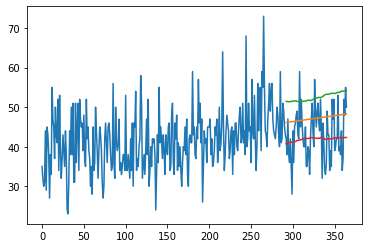

In [20]:
mean_error = estimate_pred_err(y,gscv.best_forecaster_, cv)
upper_bound = y_pred + mean_error
lower_bound = y_pred - mean_error
plt.plot(np.arange(len(y_total)), y_total)
plt.plot(np.arange(split, split+len(y_pred)), y_pred)
plt.plot(np.arange(split, split+len(y_pred)), upper_bound)
plt.plot(np.arange(split, split+len(y_pred)), lower_bound)
plt.show()